In [39]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

import warnings

# Suppress specific warning types
warnings.filterwarnings("ignore")

from pmdarima import auto_arima

## Data Preparation for ARIMA models

- same data prep as for arima, nothing changed.

In [6]:
pred_var = 'Additional_Doses_Vax_Pct'
 
df = pd.read_csv('df_post_eda.csv') 

df['Date'] = pd.to_datetime(df['Date'])
df = df.groupby('Date')[pred_var].mean()

#subset data to be only dates and predictin variable values
data = pd.DataFrame(df)

# resambpling to weekly datetime to prevent convergence warnings
data = data.resample('W').sum()

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
data = pd.DataFrame(min_max_scaler.fit_transform(data), columns=data.columns, index=df.index)


## AUTOARIMA MODEL

In [7]:
# Split data into test and train

split_date = int(len(data) * 0.8)
data = data.sort_index(ascending=True)

# Split the data
train_data = data.iloc[:split_date]
test_data = data.iloc[split_date:]

## Initial Model

- initial model informed by previous data knowledge from arima, non staionary data, no seasonality

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   64
Model:               SARIMAX(0, 2, 1)   Log Likelihood                 228.036
Date:                Thu, 23 Nov 2023   AIC                           -450.072
Time:                        18:59:49   BIC                           -443.691
Sample:                    11-03-2021   HQIC                          -447.567
                         - 01-18-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0011      0.001     -1.834      0.067      -0.002     7.5e-05
ma.L1         -0.3072      0.083     -3.688      0.000      -0.470      -0.144
sigma2      3.728e-05   4.38e-06      8.509      0.0

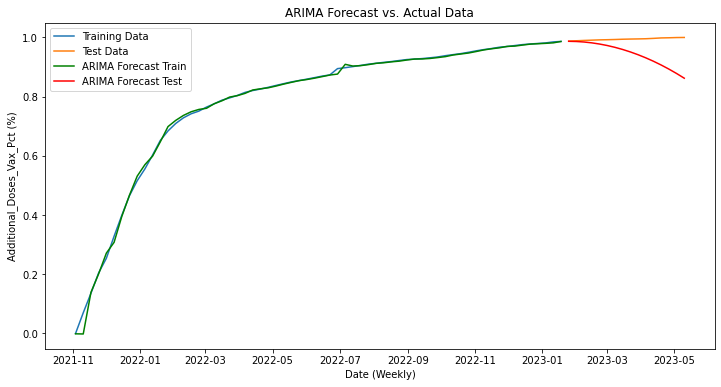

In [20]:
# stepwise = True, stepwise search, Random Search
base_model = auto_arima(train_data,
                      stationary = False,
                   seasonal = False,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(base_model.summary())

# Make predictions on the training set
train_preds = base_model.predict_in_sample()
print('--------------------------------------------------------')
# Print RMSE on the training set
train_rmse = np.sqrt(mean_squared_error(train_data, train_preds))
print(f"RMSE on training set: {train_rmse}")

# Make predictions on the test set
test_preds = base_model.predict(n_periods=len(test_data))

# Print RMSE on the test set
test_rmse = np.sqrt(mean_squared_error(test_data, test_preds))
print(f"RMSE on test set: {test_rmse}")

# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(train_data.index, train_preds, label='ARIMA Forecast Train', color='green' )
plt.plot(test_data.index, test_preds, label='ARIMA Forecast Test', color='red')
plt.legend()
plt.title('ARIMA Forecast vs. Actual Data')
plt.xlabel('Date (Weekly)')
plt.ylabel('Additional_Doses_Vax_Pct (%)')
plt.show()

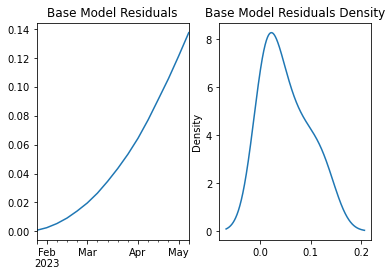

In [22]:
# Plot residual errors
#plt.figure(figsize=(12, 6))
forecast_test_df = test_preds.to_frame()
forecast_test_df['residuals']=test_data.values - forecast_test_df.values
residuals = forecast_test_df.residuals

fig, ax = plt.subplots(1,2)
residuals.plot(title="Base Model Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Base Model Residuals Density', ax=ax[1])
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   64
Model:               SARIMAX(0, 2, 5)   Log Likelihood                 233.350
Date:                Thu, 23 Nov 2023   AIC                           -452.700
Time:                        19:02:19   BIC                           -437.810
Sample:                    11-03-2021   HQIC                          -446.854
                         - 01-18-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0010      0.001     -0.895      0.371      -0.003       0.001
ma.L1         -0.3242      0.171     -1.896      0.058      -0.659       0.011
ma.L2          0.1602      0.131      1.225      0.2

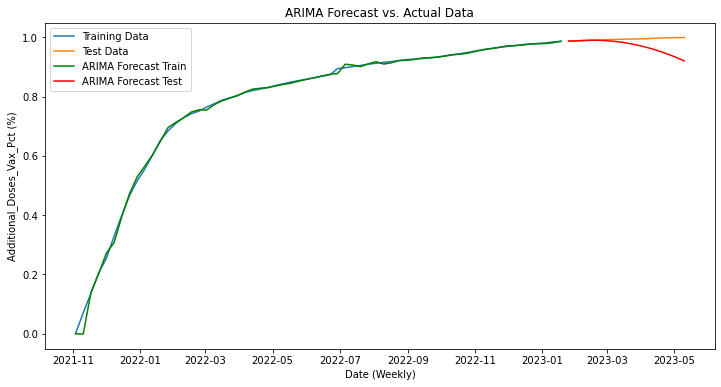

In [23]:
# grid search, more exhaustive
base_model = auto_arima(train_data,
                      stationary = False,
                   seasonal = False,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False)

print(base_model.summary())

# Make predictions on the training set
train_preds = base_model.predict_in_sample()
print('--------------------------------------------------------')
# Print RMSE on the training set
train_rmse = np.sqrt(mean_squared_error(train_data, train_preds))
print(f"RMSE on training set: {train_rmse}")

# Make predictions on the test set
test_preds = base_model.predict(n_periods=len(test_data))

# Print RMSE on the test set
test_rmse = np.sqrt(mean_squared_error(test_data, test_preds))
print(f"RMSE on test set: {test_rmse}")

# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(train_data.index, train_preds, label='ARIMA Forecast Train', color='green' )
plt.plot(test_data.index, test_preds, label='ARIMA Forecast Test', color='red')
plt.legend()
plt.title('ARIMA Forecast vs. Actual Data')
plt.xlabel('Date (Weekly)')
plt.ylabel('Additional_Doses_Vax_Pct (%)')
plt.show()

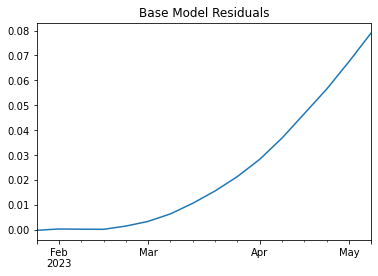

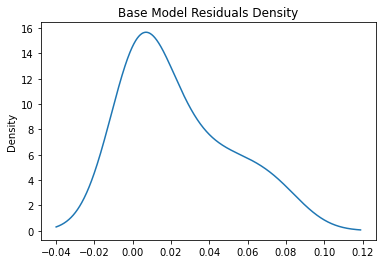

In [26]:
# Plot residual errors
#plt.figure(figsize=(12, 6))
forecast_test_df = test_preds.to_frame()
forecast_test_df['residuals']=test_data.values - forecast_test_df.values
residuals = forecast_test_df.residuals


residuals.plot(title="Base Model Residuals")
plt.show()
residuals.plot(kind='kde', title='Base Model Residuals Density')
plt.show()

In [52]:
# one day rolling forecast

In [46]:
# Set the training size and the number of steps to forecast
train_size = 64
forecast_steps = 16

# Initialize an empty array to store the forecasts
forecasts = []

# Perform a one-day rolling forecast
for i in range(train_size, len(data)):
    train_data = data[:i]
    
    # Fit AutoARIMA model
    model = auto_arima(train_data, seasonal=False,stationary = False, suppress_warnings=False)
    
    # Forecast the next one day
    forecast = model.predict(n_periods=1, return_conf_int=False)
    
    # Append the forecast to the list
    forecasts.append(forecast[0])

# Print or use the forecasts as needed
print("Forecasts:", forecasts)
print('RMSE on Test Data:', np.sqrt(mean_squared_error(test_data,forecasts)))


Forecasts: [0.9870457470575653, 0.9875035814166373, 0.988552303649198, 0.9895638830692848, 0.9904298470620233, 0.9914158632301509, 0.9916534880704423, 0.9923414693417997, 0.9935072274404925, 0.9939251004247488, 0.9942809424889149, 0.9949323014279866, 0.9966444062765362, 0.9984968162166248, 0.9984785138258865, 0.9992006872572419]
RMSE on Test Data: 0.001324973347753257


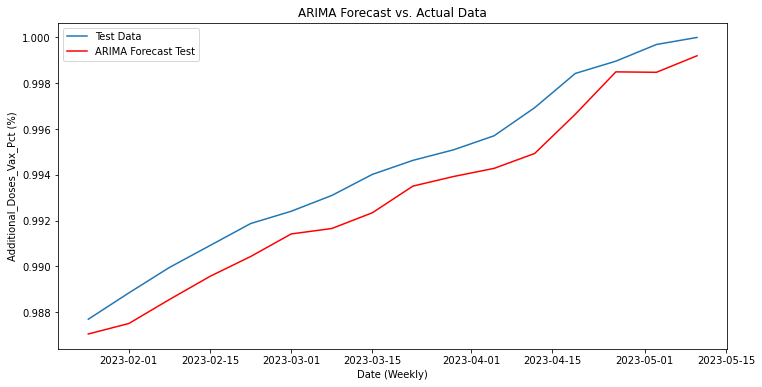

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(test_data, label='Test Data')
plt.plot(test_data.index, pd.Series(forecasts), label='ARIMA Forecast Test', color='red')
plt.legend()
plt.title('ARIMA Forecast vs. Actual Data')
plt.xlabel('Date (Weekly)')
plt.ylabel('Additional_Doses_Vax_Pct (%)')
plt.show()

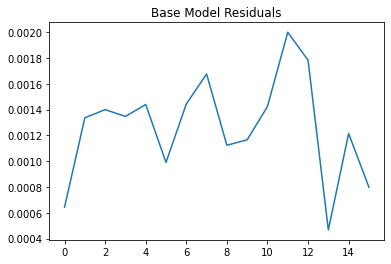

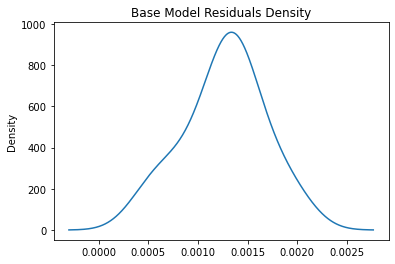

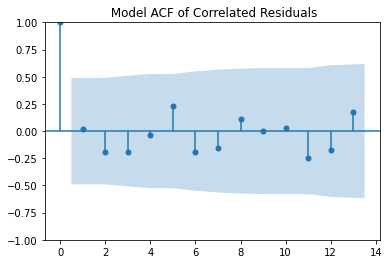

In [51]:
from statsmodels.graphics.tsaplots import plot_acf
forecast_test_df = pd.DataFrame(forecasts)
forecast_test_df['residuals']=test_data.values - forecast_test_df.values
residuals = forecast_test_df.residuals
residuals.plot(title="Base Model Residuals")
plt.show()
residuals.plot(kind='kde', title='Base Model Residuals Density')
plt.show()
plt.figsize=(10, 8)
acf_original = plot_acf(residuals)
plt.title(" Model ACF of Correlated Residuals")
plt.show()

- the ARIMA model has better performance, our data is quite simple and small in size. Because of this auto_arima may introduce unnecessary complexity to the model. 
- Auto Arima does param search automatically and fits it based on what gives the best model based on the evaluation criteria.
- challenges included the rmse not changing much for any changes in parameters.
- rolling forecast did better than regular Auto_Arima, however it did not perform as well as the ARIMA, based on the plots.

NEXT STEPS:
- exegonous variables?